In [1]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 

No pytransport functionality
No pytransport functionality


# LOAD LINE

In [2]:
def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    print('vmabc.4l2.b.b2_aper' in aperture_offsets.keys())
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers



In [3]:
config_file ='config_sim.yaml'

with open(config_file, 'r') as stream:
    config_dict = yaml.safe_load(stream)

coll_file = config_dict['input_files']['collimators']
with open(coll_file, 'r') as stream:
    coll_dict = yaml.safe_load(stream)['collimators']['b'+config_dict['run']['beam']]


run_dict = config_dict['run']
file_dict = config_dict['input_files']


context = xo.ContextCpu(omp_num_threads='auto')

# On a modern CPU, we get ~5000 particle*turns/s
# So this script should take around half an hour
beam          = run_dict['beam']
plane         = run_dict['plane']

num_turns     = run_dict['turns']
num_particles = run_dict['nparticles']
engine        = run_dict['engine']

TTCS_align_angle_step = run_dict['TTCS_align_angle_step']

#--------------------------------------------------
num_turns     = 100 #run_dict['turns']
num_particles = 200 #run_dict['nparticles']
mode = 'monitors' #run_dict['mode']
#--------------------------------------------------

path_out = Path.cwd() / 'Outputdata'

if not path_out.exists():
    os.makedirs(path_out)


# Load from json
line = xt.Line.from_json(file_dict[f'line_b{beam}'])

end_s = line.get_length()

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'


TCCS_loc = end_s - 6773.7 #6775
TCCP_loc = end_s - 6653.3 #6655
TARGET_loc = end_s - (6653.3 + coll_dict[TCCP_name]["length"]/2 + coll_dict[TARGET_name]["length"]/2)
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]




line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TARGET_name+'_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')


TCCS_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
TARGET_monitor = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
dx = 1e-11
line.insert_element(at_s = TCCS_loc - coll_dict[TCCS_name]["length"]/2 - dx, element=TCCS_monitor, name='TCCS_monitor')
line.insert_element(at_s = TARGET_loc - coll_dict[TARGET_name]["length"]/2 - dx, element=TARGET_monitor, name='TARGET_monitor')

#line.cycle(name_first_element='ip3', inplace=True)

bad_aper = find_bad_offset_apertures(line)
print('Bad apertures : ', bad_aper)
print('Replace bad apertures with Marker')
for name in bad_aper.keys():
    line.element_dict[name] = xt.Marker()
    print(name, line.get_s_position(name), line.element_dict[name])



# Aperture model check
print('\nAperture model check on imported model:')
df_imported = line.check_aperture()
assert not np.any(df_imported.has_aperture_problem)


print('\n Before collimator manager')
for i, n in enumerate(line.element_names):
    if n.startswith("TCCS"):
        print(i, n)

# Initialise collmanager
coll_manager = xc.CollimatorManager.from_yaml(file_dict['collimators'], line=line, beam=beam, _context=context, ignore_crystals=False)


#print(coll_manager.collimator_names)

# Install collimators into line
if engine == 'everest':
    coll_names = coll_manager.collimator_names

    if mode == 'cry_black_absorbers':
        black_absorbers = ['target.4l3.b2', 'tccs.5r3.b2']
    elif mode == 'angular_scan': 
        black_absorbers = ['target.4l3.b2',]
    else: 
        black_absorbers = []

    everest_colls = [name for name in coll_names if name not in black_absorbers]
    coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
    coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)


else:
    raise ValueError(f"Unknown scattering engine {engine}!")

print('\n After collimator manager')
for i, n in enumerate(line.element_names):
    if n.startswith("TCCS"):
        print(i, n)


# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)



    
# Build the tracker
coll_manager.build_tracker()



# Set the collimator openings based on the colldb,
# or manually override with the option gaps={collname: gap}
coll_manager.set_openings()


if mode == 'angular_scan':
    print("\nTTCS aligned to beam: ", line[TTCS_name].align_angle)
    #line[TTCS_name].align_angle = TTCS_align_angle_step

    line[TTCS_name].align_angle = line[TTCS_name].align_angle + TTCS_align_angle_step
    print("TTCS align angle incremented by step: ", line[TTCS_name].align_angle)


# Aperture model check
print('\nAperture model check after introducing collimators:')
df_with_coll = line.check_aperture()

#assert not np.any(df_with_coll.has_aperture_probl

Done loading line from dict.           
True
Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.04, 0.04, -0.04, 0.04, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)

Aperture model check on imported model:
Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]

 Before collimator manager
77296 TCCS_monitor
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tcl.4l1.b2           as EverestCollimator
Installing tcl.5l1.b2           as EverestCollimator
Installing tcl.6l1.b2           as EverestCollimator
Installing tctph.4r8.b2         as EverestCollimator
Installing tctpv.4r8.b2         as EverestCollimator
Installing tdisa.a4r8.b2        as EverestCol

/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)



Aperture model check after introducing collimators:
Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


#### MULTITURN ANALYSIS

    # Generate initial pencil distribution on horizontal collimator
    tcp  = f"tcp.{'c' if plane=='H' else 'd'}6{'l' if beam=='1' else 'r'}7.b{beam}"
    part = coll_manager.generate_pencil_on_collimator(tcp, num_particles=num_particles)


    # Optimise the line
    #line.optimize_for_tracking()
    idx = line.element_names.index(tcp)
    part.at_element = idx
    part.start_tracking_at_element = idx


    # Track
    coll_manager.enable_scattering()
    line.track(part, num_turns=num_turns, time=True)
    coll_manager.disable_scattering()
    print(f"Done tracking in {line.time_last_track:.1f}s.")


    # Save lossmap to json, which can be loaded, combined (for more statistics),
    # and plotted with the 'lossmaps' package
    _ = coll_manager.lossmap(part, file=Path(path_out,f'lossmap_B{beam}{plane}.json'))


    # Save a summary of the collimator losses to a text file
    summary = coll_manager.summary(part) #, file=Path(path_out,f'coll_summary_B{beam}{plane}.out')
    print(summary)

    if mode == 'cry_black_absorbers':
        df_part = part.to_pandas()
        df_part.to_hdf(Path(path_out,f'particles_B{beam}{plane}.h5'), key='df', mode='w') 


    if mode == 'monitors':
        TCCS_monitor_dict = TCCS_monitor.to_dict()
        TARGET_monitor_dict = TARGET_monitor.to_dict()
        with open(Path(path_out,f'TCCS_monitor_B{beam}{plane}.pkl'), 'wb') as f:
            pickle.dump(TCCS_monitor_dict, f)
        with open(Path(path_out,f'TARGET_monitor_B{beam}{plane}.pkl'), 'wb') as f:
            pickle.dump(TARGET_monitor_dict, f)
        

In [4]:
twiss = line.twiss()
beta_y_optics = twiss['bety',TCCS_name]
alfa_y_optics = twiss['alfy',TCCS_name]
normalized_emittance = 3.5e-6
emittance_phy = normalized_emittance/(line.particle_ref._xobject.beta0[0]*line.particle_ref._xobject.gamma0[0])
sigma = np.sqrt(emittance_phy*beta_y_optics)

In [5]:
idx_TCCS = line.element_names.index(TCCS_name)
idx_TARGET = line.element_names.index(TARGET_name)

In [6]:
line.elements[idx_TCCS].jaw_L/sigma

5.0

#### Crystal


In [145]:
getattr(line.elements[idx_TCCS], 'jaw')

In [8]:
line.elements[idx_TCCS].align_angle

-1.1763616021881982e-05

In [9]:
line.elements[idx_TCCS].to_dict()

{'__class__': 'EverestCrystal',
 'inactive_front': 0.0,
 'active_length': 0.004,
 'inactive_back': 0.0,
 'active': 1,
 'align_angle': -1.1763616021881982e-05,
 'bend': 80.0,
 'xdim': 0.002,
 'ydim': 0.035,
 'thick': 0.0,
 'miscut': 0.0,
 'rutherford_rng': {'__class__': 'RandomRutherford',
  'lower_val': 0.0009982,
  'upper_val': 0.02,
  'A': 0.0016160247264725453,
  'B': 166.49518410000002,
  'Newton_iterations': 7},
 '_tracking': 0,
 'angle': 90.0,
 'tilt': 0.0,
 'jaw': None,
 'reference_center': [-1.7331272144205038e-06, -6.174001066619167e-07],
 'side': 'left',
 'lattice': 'strip',
 'material': {'__class__': 'CrystalMaterial',
  'Z': 14.0,
  'A': 28.08,
  'density': 2.33,
  'excitation_energy': 1.73e-07,
  'nuclear_radius': 0.441,
  'nuclear_elastic_slope': 120.14,
  'cross_section': array([6.64e-01, 4.30e-01, 0.00e+00, 0.00e+00, 0.00e+00, 3.90e-04]),
  'hcut': 0.02,
  'name': 'Silicon',
  'crystal_radiation_length': 0.0937,
  'crystal_nuclear_length': 0.4652,
  'crystal_plane_dista

In [10]:
coll_dict[TCCS_name]

{'parking': 0.025,
 'gap': 5.0,
 'stage': 'special',
 'material': 'Si',
 'side': 'left',
 'angle': 90,
 'crystal': 'strip',
 'active': True,
 'length': 0.004,
 'bend': 80.0,
 'xdim': 0.002,
 'ydim': 0.035}

In [11]:
print(f"TurnAnalysis(element_type=\'crystal\', sigma={coll_dict[TCCS_name]['gap']}, length={coll_dict[TCCS_name]['length']}, xdim={coll_dict[TCCS_name]['xdim']}, ydim={coll_dict[TCCS_name]['ydim']}, align_angle={line.elements[idx_TCCS].align_angle}, jaw_L={line.elements[idx_TCCS].jaw_L})")

TurnAnalysis(element_type='crystal', sigma=5.0, length=0.004, xdim=0.002, ydim=0.035, align_angle=-1.1763616021881982e-05, jaw_L=0.0016912979598174786)


#### Target

In [12]:
line.elements[idx_TARGET]

EverestCollimator(inactive_front=0.0, active_length=0.005, inactive_back=0.0, jaw_L=0.00923702412365808, jaw_R=-0.025, ref_x=5.122714843017597e-07, ref_y=-1.2329827900582934e-06, sin_zL=1.0, cos_zL=6.123233995736766e-17, sin_zR=1.0, cos_zR=6.123233995736766e-17, sin_yL=0.0, cos_yL=1.0, tan_yL=1.0, sin_yR=0.0, cos_yR=1.0, tan_yR=1.0, _side=1, active=1, _internal_record_id=RecordIdentifier(buffer_id=0, offset=0), _material=Material(Z=67.7, A=166.7, density=18.0, excitation_energy=6.822e-07, nuclear_radius=0.578, nuclear_elastic_slope=392.1, cross_section=[2.548   1.473   0.      0.      0.      0.00574], hcut=0.02, name=Inermet, radiation_length=0.00385), rutherford_rng=RandomRutherford(lower_val=0.0009982, upper_val=0.02, A=0.0020688250909133275, B=286.00931239999994, Newton_iterations=7), _tracking=0)

In [13]:
line.elements[idx_TARGET].to_dict()

{'__class__': 'EverestCollimator',
 'inactive_front': 0.0,
 'active_length': 0.005,
 'inactive_back': 0.0,
 'active': 1,
 'rutherford_rng': {'__class__': 'RandomRutherford',
  'lower_val': 0.0009982,
  'upper_val': 0.02,
  'A': 0.0020688250909133275,
  'B': 286.00931239999994,
  'Newton_iterations': 7},
 '_tracking': 0,
 'angle': 90.0,
 'tilt': 0.0,
 'jaw': None,
 'reference_center': [5.122714843017597e-07, -1.2329827900582934e-06],
 'side': 'left',
 'material': {'__class__': 'Material',
  'Z': 67.7,
  'A': 166.7,
  'density': 18.0,
  'excitation_energy': 6.822e-07,
  'nuclear_radius': 0.578,
  'nuclear_elastic_slope': 392.1,
  'cross_section': array([2.548  , 1.473  , 0.     , 0.     , 0.     , 0.00574]),
  'hcut': 0.02,
  'name': 'Inermet',
  'radiation_length': 0.00385}}

In [14]:
coll_dict[TARGET_name]

{'parking': 0.025,
 'gap': 25,
 'stage': 'special',
 'material': 'Iner',
 'side': 'left',
 'angle': 90,
 'active': True,
 'length': 0.005,
 'xdim': 0.008,
 'ydim': 0.004}

In [15]:
print(f"TurnAnalysis(element_type=\'target\', sigma={coll_dict[TARGET_name]['gap']}, length={coll_dict[TARGET_name]['length']}, xdim={coll_dict[TARGET_name]['xdim']}, ydim={coll_dict[TARGET_name]['ydim']}, jaw_L={line.elements[idx_TARGET].jaw_L})")

TurnAnalysis(element_type='target', sigma=25, length=0.005, xdim=0.008, ydim=0.004, jaw_L=0.00923702412365808)


## Class

In [129]:
class TurnAnalysis():

    def __init__(self, element_type, sigma, length, xdim, ydim, jaw_L, align_angle = 0, beam = 2, plane = 'V', energy =6.8e12, ):

        self.beam = beam
        self.plane = plane
        self.energy = energy
        self.element_type = element_type
        self.sigma = sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.align_angle = align_angle
        self.jaw_L = jaw_L
        self.nturns = None
        self.npart = None
        self.data_dict = None
        self.data = None
        self.type = None
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.ydim/2
        


    def load(self, pkl_file_path):

        if not hasattr(pkl_file_path, '__iter__') or isinstance(pkl_file_path, str):
            pkl_file_path = [pkl_file_path]

        data_dict = {'x': np.empty(0), 'y': np.empty(0), 'px': np.empty(0), 'py': np.empty(0), 'zeta': np.empty(0), 'delta': np.empty(0), 'state': np.empty(0), 'at_element': np.empty(0), }
        npart = 0

        fi = 1 

        for file in pkl_file_path:
            try:
                with open(file, 'rb') as f:
                    loaded_dict = pickle.load(f)
            except (pickle.UnpicklingError, EOFError, FileNotFoundError) as e:
                print(f"Error loading data from {file}: {e}")
                continue
            if fi and loaded_dict:
                nturns = loaded_dict['stop_at_turn'] - loaded_dict['start_at_turn']
                fi = 0
            npart = npart + loaded_dict['part_id_end'] - loaded_dict['part_id_start']

            for key, value in data_dict.items():
                data_dict[key] = np.concatenate((value, np.array(loaded_dict['data'][key]))) 
        self.npart = npart
        self.nturns = nturns
        

        for key, value in data_dict.items():
                data_dict[key] = value.reshape(npart, nturns)

        self.data_dict = data_dict

        data_arrays = []
        for key, matrix in data_dict.items():
            data_arrays.append(xr.DataArray(matrix, dims=('id', 'turn'), name=key))

        data = xr.concat(data_arrays, dim='property')
        data = data.assign_coords(id = np.arange(npart), property = list(data_dict.keys()), turn = np.arange(nturns))
        
        self.data = data


    def plot_alive(self):
        alive_part = []
        for turn in range(self.nturns):
            alive_part.append(self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True).shape[1])

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.data.coords['turn'], alive_part)
        ax.set_xlabel('turn')
        ax.set_ylabel('Number of particles')



    def plot_distributions_at_turn(self, turn, dimensions=False):
        alive_arr = self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True)[:,:,turn]
        if dimensions:
            alive_arr = alive_arr.where(((alive_arr.loc[ 'x', :] > self.abs_x_low) & (alive_arr.loc[ 'x', :] < self.abs_x_up) & (alive_arr.loc[ 'y', :] > self.abs_y_low) & (alive_arr.loc[ 'y', :] < self.abs_y_up)), drop = True)
        
        if alive_arr.shape[1] == 0:
            print("No particles!")
            return

        fig1 = plt.figure( figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(alive_arr.loc['x', :], bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        #ax1.set_yscale("log")
        ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{2}f}" for x in plt.xticks()[0]])
        


        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(alive_arr.loc['y',:], bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.set_ylabel('')
        #ax2.set_yscale("log")
        ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{2}f}" for x in plt.xticks()[0]])
        ax2.set_title(f'Total particles: {alive_arr.shape[1]}')

        ax3 = fig1.add_subplot(2,3,3)
        h = ax3.hist2d(alive_arr.loc['x', :], alive_arr.loc['y', :], bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax3.set_xlabel(r'x [mm]')
        #ax3.set_ylim(0,0.008)
        ax3.set_ylabel(r'y [mm]')
        ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{2}f}" for x in plt.xticks()[0]])
        ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e3:.{2}f}" for y in plt.yticks()[0]])

        axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax3.grid(linestyle=':')




        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(alive_arr.loc['px', :], bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")
        #ax12.set_yscale("log")
        ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{1}f}" for x in plt.xticks()[0]])


        ax22 = fig1.add_subplot(2,3,5)
        ax22.hist(alive_arr.loc['py', :], bins=100) 
        ax22.set_xlabel(r'py [$\mu$rad]')
        ax22.set_ylabel('')
        #ax22.set_yscale("log")
        #ax22.axvline(py_central, color = 'red', linestyle = '-', alpha = 0.8)
        #ax22.axvline(py_central + critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
        #ax22.axvline(py_central - critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
        ax22.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{1}f}" for x in plt.xticks()[0]])
        #chann = len(cry_impact_parts[(cry_impact_parts.py > py_central - critical_angle) & (cry_impact_parts.py < py_central + critical_angle)])
        #ax22.set_title(f'N particle inside critical angle range: {chann}')

        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(alive_arr.loc['px', :], alive_arr.loc['py', :], bins=100, norm=matplotlib.colors.LogNorm())  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{1}f}" for x in plt.xticks()[0]])
        ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e6:.{1}f}" for y in plt.yticks()[0]])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        #fig1.suptitle('plot')
        plt.show()
        #return fig1, [ax1,ax2,ax3]


    def plot_particle_history(self, property_name, part_id):

        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(self.data.coords['turn'], self.data.loc[property_name, part_id])
        ax.set_xlabel('turn')
        ax.set_ylabel(property_name)


    def count_upper_lower(self, turn):
        alive_y = self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True).loc['y',:,turn]
        print(f'Alive particle after at {self.element_type} at {turn} turn: ', len(alive_y))
        print(f'Upper particles at {self.element_type}: ', len(alive_y.where(alive_y > 0, drop = True)))
        print(f'Lower particles at {self.element_type}: ', len(alive_y.where(alive_y < 0, drop = True)))


    def impacting_particles(self):
        x, y, px, py, ids = np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,)), np.empty((0,))
        for turn in range(self.nturns):
            impact_part = self.data.where(self.data.loc[ 'state', :, turn] > 0, drop = True)[:,:,turn]
            impact_part = impact_part.where(((impact_part.loc[ 'x', :] > self.abs_x_low) & (impact_part.loc[ 'x', :] < self.abs_x_up) & (impact_part.loc[ 'y', :] > self.abs_y_low) & (impact_part.loc[ 'y', :] < self.abs_y_up)), drop = True)
            if(impact_part.shape[1]>0):
                id_turn = np.array(impact_part.coords['id'])
                ids = np.concatenate((ids, id_turn))
                #x = np.concatenate((x, impact_part))
                print(impact_part.loc['x', :])
        return ids

    #def dimensions(self):


In [130]:
def retreive_file_path(prefix_name, path = '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/'):

    test_list = [path + i for i in os.listdir(path) if prefix_name in i]
    for test_name in test_list:

        n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

        TARGET_dict =[]
        TCCS_dict =[]

        for i in range(n_jobs):
            file_path_TARGET = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/TARGET*.pkl', shell=True)).decode('ascii').strip()
            if os.path.exists(file_path_TARGET):
                TARGET_dict.append(file_path_TARGET)

            file_path_TCCS = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/TCCS*.pkl', shell=True)).decode('ascii').strip()
            if os.path.exists(file_path_TCCS):
                TCCS_dict.append(file_path_TCCS)

        n_jobs_verify_TARGET  = len(TARGET_dict)
        n_jobs_verify_TCCS  = len(TCCS_dict)
        if n_jobs != n_jobs_verify_TARGET:
            print("!!! Succesful Jobs for TARGET: ", n_jobs_verify_TARGET, '/', n_jobs, ' in file: ', test_name)
        if n_jobs != n_jobs_verify_TCCS:
            print("!!! Succesful Jobs for TCCS: ", n_jobs_verify_TCCS, '/', n_jobs, ' in file: ', test_name)

    return TARGET_dict, TCCS_dict

In [131]:
#list_TARGET_xsuite, list_TCCS_xsuite = retreive_file_path('TEST_xsuite')

In [132]:
#list_TARGET_simple, list_TCCS_simple = retreive_file_path('TEST_simple_model')

## Analysis

In [133]:
TCCS = TurnAnalysis(element_type='crystal', sigma=5.0, length=0.004, xdim=0.002, ydim=0.035, align_angle=-1.1763616021881982e-05, jaw_L=0.0016912979598174786)
TARGET = TurnAnalysis(element_type='target', sigma=25, length=0.005, xdim=0.008, ydim=0.004, jaw_L=0.00923702412365808)

In [134]:
TCCS.load('Outputdata/TCCS_monitor_B2V_simple_model.pkl')
TARGET.load('Outputdata/TARGET_monitor_B2V_simple_model.pkl')
#TARGET.load(list_TARGET_xsuite[-5:])

In [135]:
TARGET.impacting_particles()

<xarray.DataArray 'x' (id: 26)>
array([-1.00680161e-05, -1.42584365e-04,  1.15970529e-04, -8.92250758e-05,
        1.28827018e-04, -9.90693821e-05, -8.27467051e-05,  3.70857112e-04,
        6.91414895e-05,  5.83865933e-05,  5.51317959e-05, -4.22342497e-05,
       -2.10487882e-05, -1.18184808e-04, -3.57226414e-05, -3.21326236e-05,
       -6.69395218e-06, -9.52757020e-05, -3.37986163e-05, -1.71768054e-06,
        1.29291517e-04, -1.10708430e-04, -6.71733249e-05,  6.48126948e-04,
        3.44793211e-05,  2.63694936e-06])
Coordinates:
  * id        (id) int64 516 520 522 523 536 557 569 ... 852 885 906 909 950 952
    property  <U10 'x'
    turn      int64 0
<xarray.DataArray 'x' (id: 7)>
array([-8.52403004e-06,  9.74237606e-06, -4.88536250e-06, -2.23438561e-05,
        1.13330863e-04,  2.85690885e-05, -1.40793511e-05])
Coordinates:
  * id        (id) int64 56 119 128 157 247 431 473
    property  <U10 'x'
    turn      int64 5
<xarray.DataArray 'x' (id: 12)>
array([ 9.29782984e-05, -2.852

array([516., 520., 522., 523., 536., 557., 569., 592., 596., 631., 641.,
       655., 661., 695., 737., 741., 772., 810., 832., 842., 852., 885.,
       906., 909., 950., 952.,  56., 119., 128., 157., 247., 431., 473.,
         3.,  31., 120., 227., 276., 282., 390., 413., 424., 432., 452.,
       463., 669., 745., 932., 682., 684.,  35.,  80., 371., 470., 489.,
       976., 824., 864., 989.,  21., 115., 141., 202., 204., 286., 332.,
       476., 145., 830., 513., 514., 721., 747., 903., 101., 231.,   8.,
       260., 626., 526., 542., 397.,  61., 386., 620., 689., 229., 469.,
       584., 898., 929., 228., 568., 754., 815., 837., 858., 931., 993.,
       565., 354., 822., 859., 310., 917.])

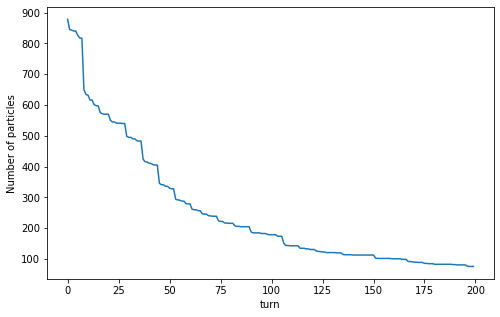

In [127]:
TCCS.plot_alive()

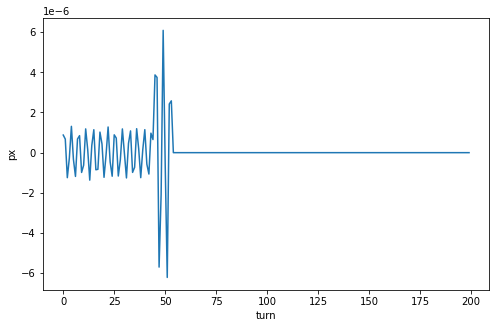

In [128]:
TCCS.plot_particle_history('px', 8)

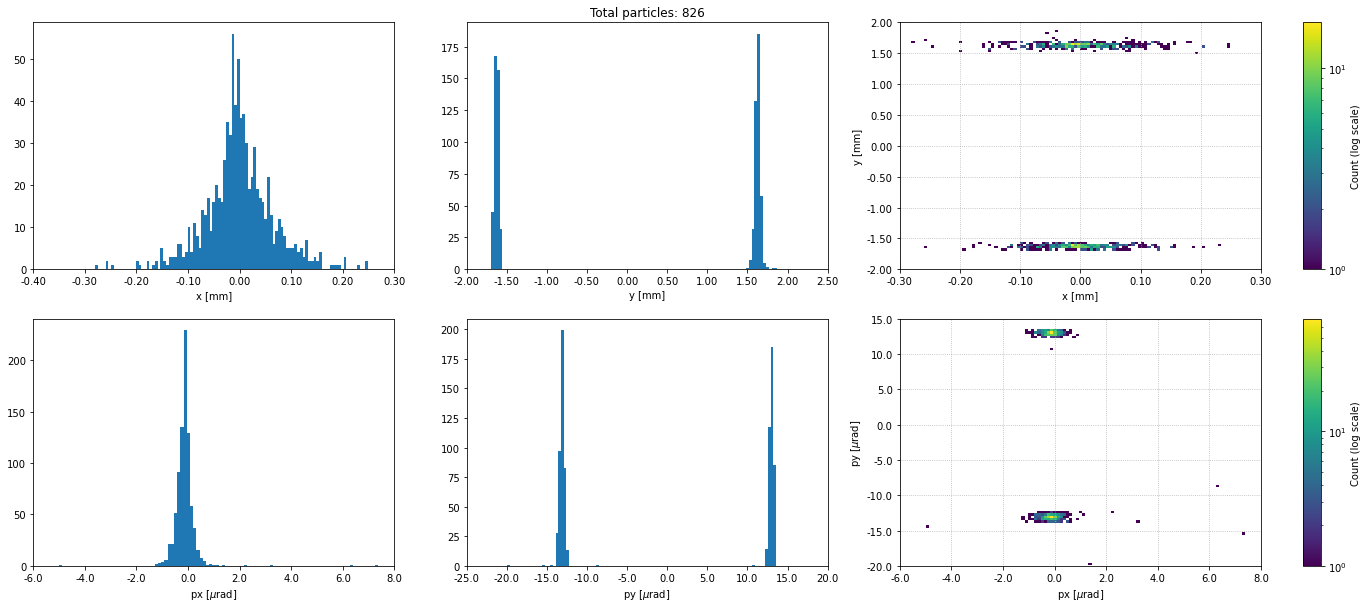

In [136]:
TCCS.plot_distributions_at_turn(5, False)

In [29]:
line.element_names[77096]

'TCCS_monitor'

In [30]:
TARGET.data.where(((TARGET.data.loc[ 'x', :, 1] > TARGET.abs_x_low) & (TARGET.data.loc[ 'x', :, 1] < TARGET.abs_x_up)), drop = True)[:,:,1].shape

(8, 1000)